## 1.1 Getting the Data
### Objective: 
##### Download DeepfakeTIMIT database to obtain the set of Deepfake videos. Once the database is downloaded, read the Readme file and playback several of the Deepfake videos (there are high- and low-quality Deepfakes) to see what they look like and how they are different.

##### Download the original VidTIMIT dataset, and check the included videos.

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
import fnmatch

#Specifying the root of our directory
root='/content/drive/'
fileroot=root+'My Drive/DeepfakeFiles/'

#Mounting my drive to get access to the datasets
from google.colab import drive
drive.mount(root)

Mounted at /content/drive/


#1.2 Processing the Data
Objective:
Use OpenCV to read videos frame by frame. Use matplotlib or OpenCV to save the frames as images. Use OpenCV to compare frames from genuine and Deepfake videos. You can compute a simple difference between original and Deepfake frames and save the difference as an image. You can also compare the histograms of original and Deepfake frames.¶


In [2]:
#Creating a function to find files in a directory
def findFiles(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename

#Creating empty lists to store our videos once we iterate through them
realVideosList = []
fakeVideosList = []

#Using the glob library to walk through our directory and append all the .avi files (the videos)
for file in findFiles(fileroot+'VidTIMIT/', '*.avi'):
  realVideosList.append(file)

for file in findFiles(fileroot+'DeepfakeTIMIT/higher_quality/', '*.avi'):
  fakeVideosList.append(file)

#Sorting the videos just so we know which video is first in each folder
realVideosList = sorted(realVideosList)
fakeVideosList = sorted(fakeVideosList)

print(realVideosList[:5])
print(fakeVideosList[:5])

['/content/drive/My Drive/DeepfakeFiles/VidTIMIT/fadg0/sa1.avi', '/content/drive/My Drive/DeepfakeFiles/VidTIMIT/fadg0/sa2.avi', '/content/drive/My Drive/DeepfakeFiles/VidTIMIT/fadg0/si1279.avi', '/content/drive/My Drive/DeepfakeFiles/VidTIMIT/fadg0/si1909.avi', '/content/drive/My Drive/DeepfakeFiles/VidTIMIT/fadg0/si649.avi']
['/content/drive/My Drive/DeepfakeFiles/DeepfakeTIMIT/higher_quality/fadg0/sa1-video-fram1.avi', '/content/drive/My Drive/DeepfakeFiles/DeepfakeTIMIT/higher_quality/fadg0/sa2-video-fram1.avi', '/content/drive/My Drive/DeepfakeFiles/DeepfakeTIMIT/higher_quality/fadg0/si1279-video-fram1.avi', '/content/drive/My Drive/DeepfakeFiles/DeepfakeTIMIT/higher_quality/fadg0/si1909-video-fram1.avi', '/content/drive/My Drive/DeepfakeFiles/DeepfakeTIMIT/higher_quality/fadg0/si649-video-fram1.avi']


In [3]:
#The next step is picking one real video and one fake video and saving all the frames of that video to the disk
#as a .jpeg by using OpenCV

#Using just the first video from each folder as an example
realVideo = realVideosList[0]
fakeVideo = fakeVideosList[0]

#Function that loops through the video and saves each frame as a .jpeg
def extractFrames(videoName):
    imageName = os.path.splitext(videoName)[0] #Making the image name the first part of the text
    capture = cv2.VideoCapture(videoName)
    
    #Getting the number of frames by using the CAP_PROP_FRAME_COUNT function
    #There's different ways of doing this, this is just how the tutorial I looked at did it
    numFrames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    for frameNum in range(numFrames):
        capture.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = capture.read()
        cv2.imwrite(imageName + '_' + str(frameNum) + '.jpg', frame)
        
#Calling the function to save the .jpg to disk
extractFrames(realVideo)
extractFrames(fakeVideo)

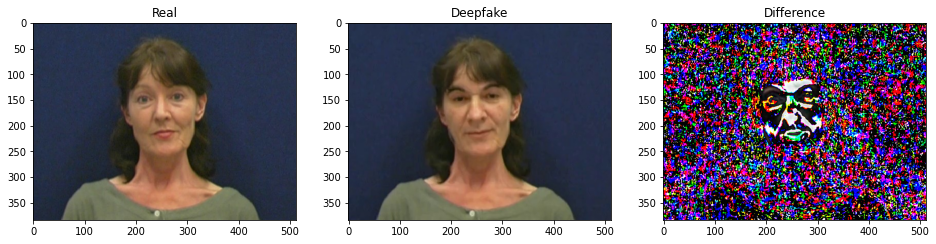

In [4]:
#To find the difference in frames, we just subtract the differences in the shape (yes, it's that easy)

#First, we'll take the first frame from a fake video and a real video
realFrame = os.path.splitext(realVideo)[0] + '_1.jpg'
fakeFrame = os.path.splitext(fakeVideo)[0] + '_1.jpg'

#Function to read the images, convert them to RGB for matplotlib, find the difference, and display them
def compareImages(realImageName, fakeImageName):
    realImage = cv2.imread(realImageName)
    fakeImage = cv2.imread(fakeImageName)
    
    realImage = cv2.cvtColor(realImage, cv2.COLOR_BGR2RGB)
    fakeImage = cv2.cvtColor(fakeImage, cv2.COLOR_BGR2RGB)
    
    imageDifference = None
    if realImage.shape == fakeImage.shape:
        imageDifference = realImage - fakeImage
        
    #Displaying the images side by side to show the differences
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(realImage)
    plt.title('Real')
    plt.subplot(1, 3, 2)
    plt.title('Deepfake')
    plt.imshow(fakeImage)
    if imageDifference is not None:
        plt.subplot(1, 3, 3)
        plt.title('Difference')
        plt.imshow(imageDifference)
    plt.show()
    return realImage, fakeImage, imageDifference

#Calling the function
realImage, fakeImage, imageDifference = compareImages(realFrame, fakeFrame)

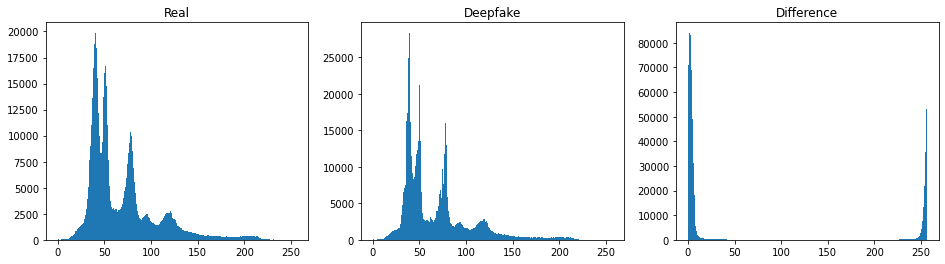

In [5]:
#In this step, we'll create a function to compute histograms using matplotlib's ravel() and hist functions
def showHistogram(realImage, fakeImage, imageDifference = None):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.title('Real')
    plt.hist(realImage.ravel(), 256, [0,256])
    plt.subplot(1, 3, 2)
    plt.title('Deepfake')
    plt.hist(fakeImage.ravel(), 256, [0,256])
    if imageDifference is not None:
        plt.subplot(1, 3, 3)
        plt.title('Difference')
        plt.hist(imageDifference.ravel(), 256, [0,256])
    plt.show()

#Calling the function to display the histograms
showHistogram(realImage, fakeImage, imageDifference)

# 1.3 Detecting Faces in Videos
### Objective: 
##### Use OpenCV or MTCNN face detectors to detect faces in each frame of the videos. OpenCV has very simple and popular Viola-Jones face detection algorithm. It is simple and fast and will work well on the videos from DeepfakeTIMIT database, since the videos show one person talking in front of the camera and the face is quite large. MTCNN is a neural network-based face detector and is more accurate than the one in OpenCV. Which face detector you use for this project is not important; you can select the one you prefer or whichever you find easier to use.

In [6]:
#Importing the neural network used to detect faces
!pip install mtcnn
from mtcnn import MTCNN
detector = MTCNN()

#You will need to install tensorflow and keras to use mtcnn.
#Type '!pip install mtcnn and run it' and 'pip install tensorflow'

#Function detect a face, convert it to RGB, and crop the image around the face
def detectFace(image, box_scale = 0.15):
    RGBImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection = detector.detect_faces(RGBImage) #Using the detect_faces function in the MTCNN library
    #Putting a box around the face
    if len(detection) > 0:
        squareBox = detection[0]['box']
        x = int(squareBox[0] - box_scale * squareBox[2])
        y = int(squareBox[1] - box_scale * squareBox[3])
        w = int(squareBox[2] + box_scale * squareBox[2] * 2)
        h = int(squareBox[3] + box_scale * squareBox[3] * 2)
        
        #Cropping the image
        return image[y:y+h, x:x+w, :].copy()
    return None

#Function to detect the faces and save the cropped images to disk
def detectAndSave(videoName, box_scale = 0.15, limitFaces = -1, saveFaces = True):
    detector = MTCNN()
    faces = list()
    # add '_face' at the end to differentiate face images
    faceName = os.path.splitext(videoName)[0] + '_face'
    
    #Reading the frames like we did before but this time only saving the faces instead of the entire frames
    capture = cv2.VideoCapture(videoName)
    numFrames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    for frameNum in range(numFrames):
        #Loop until the limit is no longer -1
        if limitFaces != -1 and frameNum >= limitFaces:
            break
        capture.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = capture.read()
        #Using our detect_face function above
        face = detectFace(frame, box_scale=box_scale)
        if face is not None:
            faces.append(face)
            if saveFaces:
                cv2.imwrite(faceName + '_' + str(frameNum) + '.jpg', face)
    return faces

#Saving the first 5 faces
realFaces = detectAndSave(realVideo, limitFaces=5)
fakeFaces = detectAndSave(fakeVideo, limitFaces=5)

     |████████████████████████████████| 2.3MB 2.8MB/s 


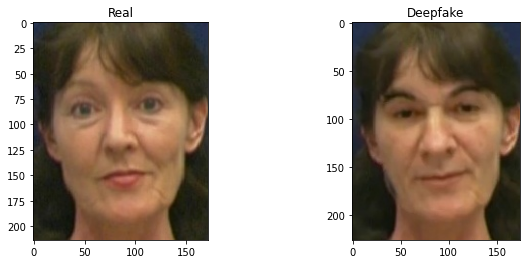

In [7]:
#Showing cropped faces side by side
realFaceExample = os.path.splitext(realVideo)[0] + '_face_1.jpg'
fakeFaceExample = os.path.splitext(fakeVideo)[0] + '_face_1.jpg'

realFace, fakeFace, _ = compareImages(realFaceExample, fakeFaceExample)

#2.1 Comparing Images
Objective:

Compare two extracted faces from genuine and Deepfake videos. You can use feature matching method provided by openCV library to visualize the matched features in two different faces. Compute Structural Similarity Index (SSIM) between two images to compare how similar they are to each other. Use template matching to compare two images. Compute histograms for the faces.



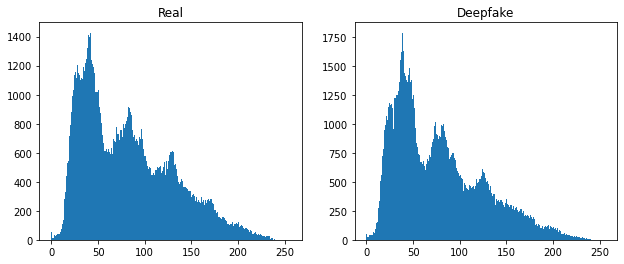

In [8]:
#Using the two images above to examine the histograms, luckily we already have a function for that
showHistogram(realFace, fakeFace)

In [9]:
#Creating functions to blur an image, compute an MSE, PSNR, and SSIM
import skimage.metrics

#Function to blur an image using Gaussian blur
def blurImage(image, kernel_size = 3, sigma = 0.5):
  return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

#Function to compute MSE
def computeMSE(x, y):
  return skimage.metrics.normalized_root_mse(x, y)

#Function to compute the PSNR
def computePSNR(x, y):
  return skimage.metrics.peak_signal_noise_ratio(x, y, data_range=255)

#Function to compute the SSIM
def computeSSIM(x, y):
    return skimage.metrics.structural_similarity(x, y, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=255)

#Instead using matplotlib to look at the histograms, let's actually compute a histogram to use as a feature
def computeHist(image, bins = 64):
  hist, bins = np.histogram(image.ravel(), bins, [0,256], density = True)
  return hist

#2.2 Define features
Objective: 
From the above methods that compare images, select those that you can use as features. One feature should not be too large and should be representative enough for later classification. Also, the features are extracted from each frame (or a face) independently, which means there is no reference image to compare to. The trick, therefore, is to synthesize that reference. One way to do it is to create a blurred version of the same image and compute features between our image and its blurred version. Store computed features in HDF5 format.

In [10]:
#Function that calls the functions above to create a single array of features
def computeFeatures(image):
  blurredImage = blurImage(image)
  mse = computeMSE(image, blurredImage)
  psnr = computePSNR(image, blurredImage)
  ssim = computeSSIM(image, blurredImage)
  hist = computeHist(image, bins = 64)
  featuresArray = np.concatenate([[mse], [psnr], [ssim], hist])
  return featuresArray

#Calling the function to return the features of the real image above
realFaceFeatures = computeFeatures(realFace)

In [11]:
#Storing the computed features as HDF5 files
import h5py

#Source for writing hdf5 files for reference: https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html
#Only using one frame for now
HDF5Path = os.path.splitext(realVideo)[0] + '_face_1.h5'

#Creating a dataset of HDF5 files
with h5py.File(HDF5Path, 'w') as hf:
  HDF5Dataset = hf.create_dataset(name = 'Features', data = realFaceFeatures)

#3.1 Features for Training Set
Objective:

Using the feature extraction from the previous chapter, compute features for all videos in the training set and save them in HDF5 files. Make sure the features for genuine and Deepfake videos are saved in separate folders, so you can know if the feature comes from original genuine video or Deepfake.

In [12]:
import h5py
import numpy as np

#Creating a function to read in the videos, detect a face in each frame, compute the features for that frame, and save the matrix as a HDF5 file
def computeFeaturesForVideos(numFeatures = 1):
  for vid in realVideosList + fakeVideosList: #Loop for as many videos there are in the directory
    HDF5Path = os.path.splitext(vid)[0] + '.h5'
    #Detecting faces in each video
    faces = detectAndSave(vid, box_scale = 0.15, limitFaces = numFeatures, saveFaces = False)
    #Computing features for each face
    faceFeatures = []
    for face in faces:
      faceFeature = computeFeatures(face)
      faceFeatures.append(faceFeature)
    #Converting the list to a numpy array for better performance
    faceFeaturesArray = np.array(faceFeatures)
    #Storing the features as an HDF5 file
    with h5py.File(HDF5Path, 'w') as hf:
      HDF5Dataset = hf.create_dataset(name = 'Features', data = faceFeaturesArray)

  #Just printing out a confirmation to make sure it worked
  print("Finished computing features")

In [13]:
#Calling the above function to compute features for all videos. I'm only doing the first two frames of each video to save time.
#Change to higher number to get a larger dataset and more accurate results
computeFeaturesForVideos(numFeatures = 2)

Finished computing features


#3.2 Train SVM Classifier
Objective:

Using scikit-learn train SVM classifier on the features. When reading the features from the saved HDF5 files, you need to also construct a vector with labels that has 0 label for each Deepfake features and 1 label for each genuine feature. You can use linear SVM and play with different parameters of this classifier and study their impact on the results.

In [14]:
from sklearn.model_selection import train_test_split

#Splitting our datasets into 80% training and 20% testing
realTrain, realTest = train_test_split(realVideosList, test_size = 0.2, random_state = 42)
fakeTrain, fakeTest = train_test_split(fakeVideosList, test_size = 0.2, random_state = 42)

In [15]:
#Creating a function to create features and labels for both the real training data and the fake training data
#This is very similar to the previous function but this one only uses the training data and disregards the testing data
def featuresAndLabels(dataset, label = 1):
  #Creating two lists to hold our features and labels
  features = []
  labels = []
  #Loading the training set
  for vid in dataset:
    HDF5Path = os.path.splitext(vid)[0] + '.h5'
    with h5py.File(HDF5Path, 'r') as hf:
      feature = np.array(hf['Features'], dtype = np.float64)
      features.append(feature)
      labels.append(np.asarray(len(feature) * [label])) #Creating a label for each row
  return features, labels

In [16]:
#Calling the function to create the features and labels of the training set
#Real faces will be identified with a 1 and fake faces will be a 0
trainRealFeatures, trainRealLabels = featuresAndLabels(realTrain, label = 1)
trainFakeFeatures, trainFakeLabels = featuresAndLabels(fakeTrain, label = 0)

In [24]:
#Putting all features and labels in a single matrix
trainingFeatures = np.concatenate([np.concatenate(trainRealFeatures, axis = 0), np.concatenate(trainFakeFeatures, axis = 0)])
trainingLabels = np.concatenate([np.concatenate(trainRealLabels, axis = 0), np.concatenate(trainFakeLabels, axis = 0)])

#Printing the shape of the matrix just to get an idea of what it looks like
print(trainingFeatures.shape)
print(trainingLabels.shape)

#Normalizing the dataset. I ran the model without this part and the precision was awful
mean = np.mean(trainingFeatures, axis = 0)
standardDeviation = np.std(trainingFeatures, axis = 0)
normalizedFeatures = (trainingFeatures - mean) / standardDeviation

#Exploring what some of the data looks like
#print(trainRealFeatures)

(1200, 67)
(1200,)


In [25]:
#Importing the SVM module to train our data using a variety of kernels
import sklearn.svm

#Creating a list of the three different types of SVM's we want to train our data with so we can compare them later
svmModels = []
for kernel in ['linear', 'sigmoid', 'rbf']:
  svm = sklearn.svm.SVC(kernel = kernel, gamma = "auto", class_weight = "balanced")
  svm.fit(normalizedFeatures, trainingLabels)
  svmModels.append(svm)

In [26]:
#Saving our models as a .sav file in the root directory
import pickle

rootFolder = os.path.dirname(fileroot)
for svm in svmModels:
  modelName = os.path.join(rootFolder, svm.kernel + '.sav')
  pickle.dump(svm, open(modelName, 'wb'))

#4.1 Evaluate the Trained Model on the Test Set
Objective:



*   Using the feature extraction from the previous milestone, compute features for all videos in the test set and save them in HDF5 files. Make sure the features for genuine and Deepfake videos are saved in a separate folders, so you can know if the feature comes from original genuine video or Deepfake.
*   Using the pre-trained linear SVM model, apply it to the features in the test set.



In [28]:
#Creating the features and labels for our test set; the same as we did before with the training data
testRealFeatures, testRealLabels = featuresAndLabels(realTest, label = 1)
testFakeFeatures, testFakeLabels = featuresAndLabels(fakeTest, label = 0)

testingFeatures = np.concatenate([np.concatenate(testRealFeatures, axis = 0), np.concatenate(testFakeFeatures, axis = 0)])
testingLabels = np.concatenate([np.concatenate(testRealLabels, axis = 0), np.concatenate(testFakeLabels, axis = 0)])

#Normalizing the testing features. Once again, without this, the accuracy is not good
normalizedTestFeatures = (testingFeatures - mean) / standardDeviation

In [29]:
#Using the linear SVM kernel to predict labels for the test set
predictions = {}
for svm in svmModels:
  predictionLabels = svm.predict(normalizedTestFeatures)
  predictions[svm.kernel] = predictionLabels

print(predictions)

{'linear': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [30]:
#Using the built in classification_report method in sklearn to see how we performed
from sklearn.metrics import classification_report
for svm in svmModels:
    print("Report for SVM Model: {}".format(svm.kernel))
    print(classification_report(testingLabels, predictions[svm.kernel]))

Report for SVM Model: linear
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       130
           1       0.95      0.98      0.97       172

    accuracy                           0.96       302
   macro avg       0.96      0.96      0.96       302
weighted avg       0.96      0.96      0.96       302

Report for SVM Model: sigmoid
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       130
           1       0.78      0.70      0.74       172

    accuracy                           0.72       302
   macro avg       0.72      0.72      0.72       302
weighted avg       0.73      0.72      0.72       302

Report for SVM Model: rbf
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       130
           1       0.96      0.98      0.97       172

    accuracy                           0.97       302
   macro avg       0.97      0.96      0.97

#4.2 Analyze the Results
Objective:

To analyze the performance of your system, you can plot the predicted scores for test set in several different ways. First, you can plot them as two histograms (genuine and Deepfake scores). You can see the distribution of the histograms and conclude if the scores are well separated or not. In a good system, the scores will be clearly separated. Then, you can plot ROC curve with scikit-learn and analyze the system’s performance for each different combination of false positive and true positive rates.

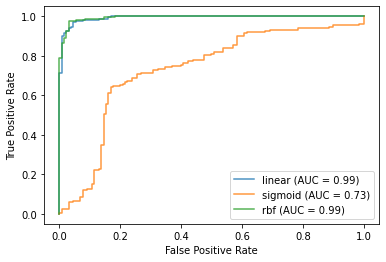

In [31]:
#Lastly, we'll graph the ROC curve for each one to get another metric of how it performed
from sklearn.metrics import plot_roc_curve
for svm in svmModels:
  graph = plot_roc_curve(svm, normalizedTestFeatures, testingLabels, ax = plt.gca(), alpha = 0.8, name = svm.kernel)

plt.show()